In [1]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [2]:
DATA_BASE_PATH = "../data/m5-forecasting-accuracy/"
SALES_EVALUATION = "sales_train_evaluation.csv"
SALES_VALIDATION = "sales_train_validation.csv"
CALENDAR = "calendar.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"
SELL_PRICES = "sell_prices.csv"

DAYS: int = 28

In [3]:
def _down_cast(df):
    """ reduce memory usage """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [4]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

In [5]:
def data_preprocessing(df):
    df = pd.melt(
        frame=df, 
        id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name="d", 
        value_name="sold"
    )
    df = pd.merge(
        left=df, 
        right=calendar, 
        how="left", 
        on="d"
    )
    df = pd.merge(
        left=df, 
        right=sell_prices, 
        on=["store_id", "item_id", "wm_yr_wk"], 
        how="left"
    )
    release_dates = sell_prices.groupby(["store_id", "item_id"])["wm_yr_wk"].agg(["min"]).reset_index()
    release_dates.columns = ["store_id", "item_id", "release"]
    df = pd.merge(
        left=df,
        right=release_dates, 
        how="left", 
        on=["store_id", "item_id"]
    )
    return df

In [6]:
df = data_preprocessing(sales_validation)
df = df[df['wm_yr_wk'] >= df['release']]

In [88]:
df['sell_price'] = df['sell_price'].astype(np.float32)

In [89]:
AGG_LEVEL_COLUMNS = {
    "Level1": [], # no grouping, sum of all
    "Level2": ['state_id'],
    "Level3": ['store_id'],
    "Level4": ['cat_id'],
    "Level5": ['dept_id'],
    "Level6": ['state_id', 'cat_id'],
    "Level7": ['state_id', 'dept_id'],
    "Level8": ['store_id', 'cat_id'],
    "Level9": ['store_id', 'dept_id'],
    "Level10": ['item_id'],
    "Level11": ['state_id', 'item_id'],
    "Level12": ['item_id','store_id'],
}

# for i, agg_level in enumerate(list(AGG_LEVEL_COLUMNS.keys())[1:]):
#     # print(agg_level)
#     print(agg_level, df.groupby(AGG_LEVEL_COLUMNS[agg_level]).ngroups)
#     sums = df.groupby(AGG_LEVEL_COLUMNS[agg_level] + ['d'])['sold'].sum().reset_index(drop=False)
#     means = sums.groupby(AGG_LEVEL_COLUMNS[agg_level])['sold'].mean()
    
#     if i > 8:
#         plt.hist(means, bins = 40) 
#     else:
#         plt.hist(means)
#     plt.show()

In [90]:
# df['date'].min(), df['date'].max()
df.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961,11101
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,1.559570,11101
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,3.169922,11101
11,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,5.980469,11101
14,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,0.700195,11101


# Plot Of Single Results

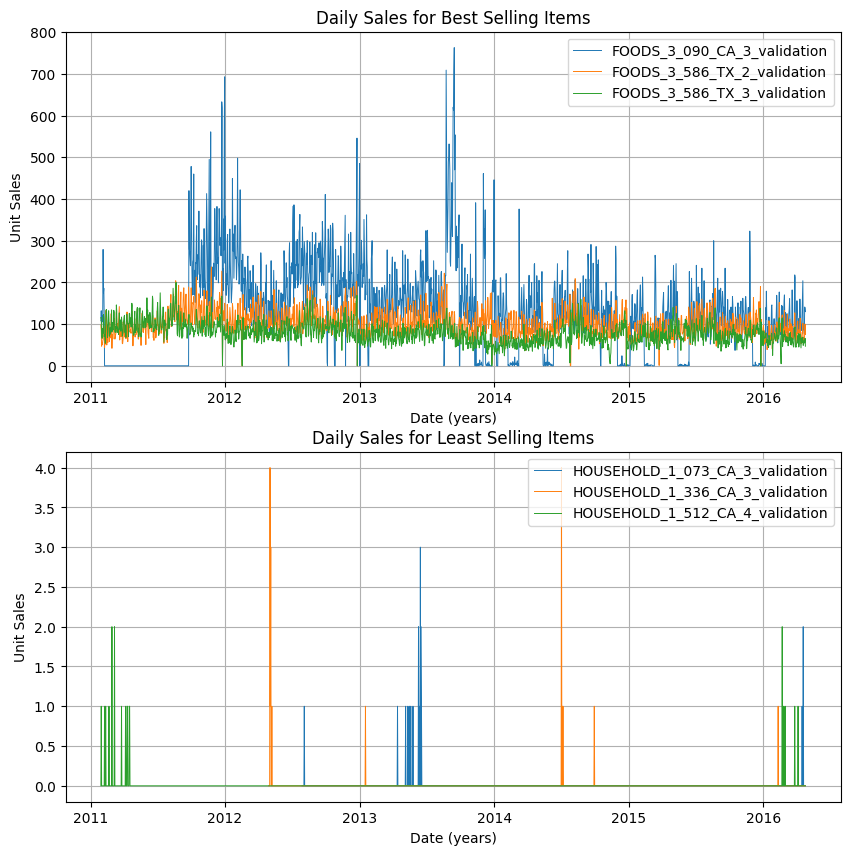

In [111]:
idx_sorted = df.groupby('id')['sold'].mean().sort_values().reset_index(drop=False)['id']
examples_low = idx_sorted.values[:3]
examples_high = idx_sorted.values[-3:]

fig, axs = plt.subplots(2,1, figsize = (10,10))
axs[0].set_title('Daily Sales for Best Selling Items')
axs[1].set_title('Daily Sales for Least Selling Items')

# HIGHEST SELLER AVG
# low_example = FOODS_3_090_CA_3_validation
ax = axs[0]
for id in examples_high[::-1]:
    df_temp = df[df['id'] == id]
    ax.plot(df_temp['date'], df_temp['sold'], label = str(id), linewidth=.7)

# LOWEST SELLER AVG
# high_example = HOUSEHOLD_1_512_CA_4_validation
ax = axs[1]
for id in examples_low[::-1]:
    df_temp = df[df['id'] == id]
    ax.plot(df_temp['date'], df_temp['sold'], label = str(id), linewidth=.7)

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel('Unit Sales')
    ax.set_xlabel('Date (years)')
    
plt.show()


In [ ]:
r = df.groupby(['item_id', 'd'])['sell_price'].std()
r.sort_values(ascending=False)

In [ ]:
df[['sold', 'sell_price']].describe()

### Plot Of State Sales Aggregated Weekly

In [ ]:
sales_by_store_and_date = df.groupby(["state_id", "wm_yr_wk"]).agg({"sold": np.sum, "date": "first"}).reset_index(drop=False)#["sold"].sum().reset_index(drop=False)
fig, axs = plt.subplots(1,1, figsize = (20,10))
for state in df.state_id.unique():
    axs.plot(sales_by_store_and_date[sales_by_store_and_date.state_id == state]["sold"].reset_index(drop=True), label = state)

axs.set_title("State Aggregated Sales By Week")
axs.set_xlabel("wm_yr_wk")
axs.set_ylabel("sold units")
axs.legend()
axs.grid()
plt.show()

### Average Daily Sales By Store

In [ ]:
df_c = df.copy()
df_c["day"] = df_c.date.dt.day
sales_aggregated_by_day = df_c.groupby(["store_id", "d"]).agg({"sold": np.sum, "day": "last"}).reset_index(drop=False)
sales_by_store_and_date = sales_aggregated_by_day.groupby(["store_id", "day"]).agg({"sold": np.mean}).reset_index(drop=False)

fig, axs = plt.subplots(1,1, figsize = (10, 5))
for store in sales_by_store_and_date.store_id.unique():
    sales_by_store_and_date[sales_by_store_and_date.store_id == store].sold.reset_index(drop=True).plot(ax = axs, label = store)

axs.set_title("Average Daily Sales By Store And Day Number")
axs.set_xlabel("day")
axs.set_ylabel("unit sales")
axs.legend()
plt.show()

# Sales Aggregated on Weekday >> Seasonality Pattern

2023-09-09 18:59:14 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-09-09 18:59:14 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


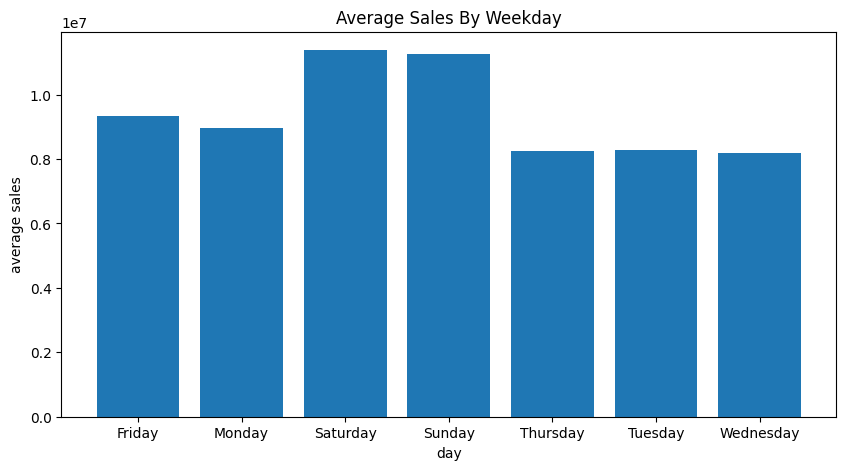

In [91]:
# average over all stores
sales_by_weekday = df.groupby(["weekday"]).agg({"sold": np.sum}).reset_index(drop=False)
fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.bar(sales_by_weekday.weekday, sales_by_weekday.sold)

axs.set_title("Average Sales By Weekday")
axs.set_xlabel("day")
axs.set_ylabel("average sales")
plt.show()

### Average Sales By Weekday For Each Store

In [ ]:
# grouped by store as well
sales_by_weekday = df.groupby(["store_id", "weekday"]).agg({"sold": np.sum, "wday": "last"}).reset_index(drop=False).sort_values(by="wday", ascending = True)
n_stores = sales_by_weekday["store_id"].nunique()

m = 4
n =  n_stores // m if n_stores % m == 0 else n_stores // m + 1
fig, axs = plt.subplots(n,m, figsize = (25, 15))

for k, store_id in enumerate(sales_by_weekday["store_id"].unique()):
    ax = axs[k // m, k % m]
    ax.bar(sales_by_weekday[sales_by_weekday["store_id"] == store_id].weekday, sales_by_weekday[sales_by_weekday["store_id"] == store_id].sold)
    ax.set_title(f"{store_id}: average daily unit sales")
plt.show()

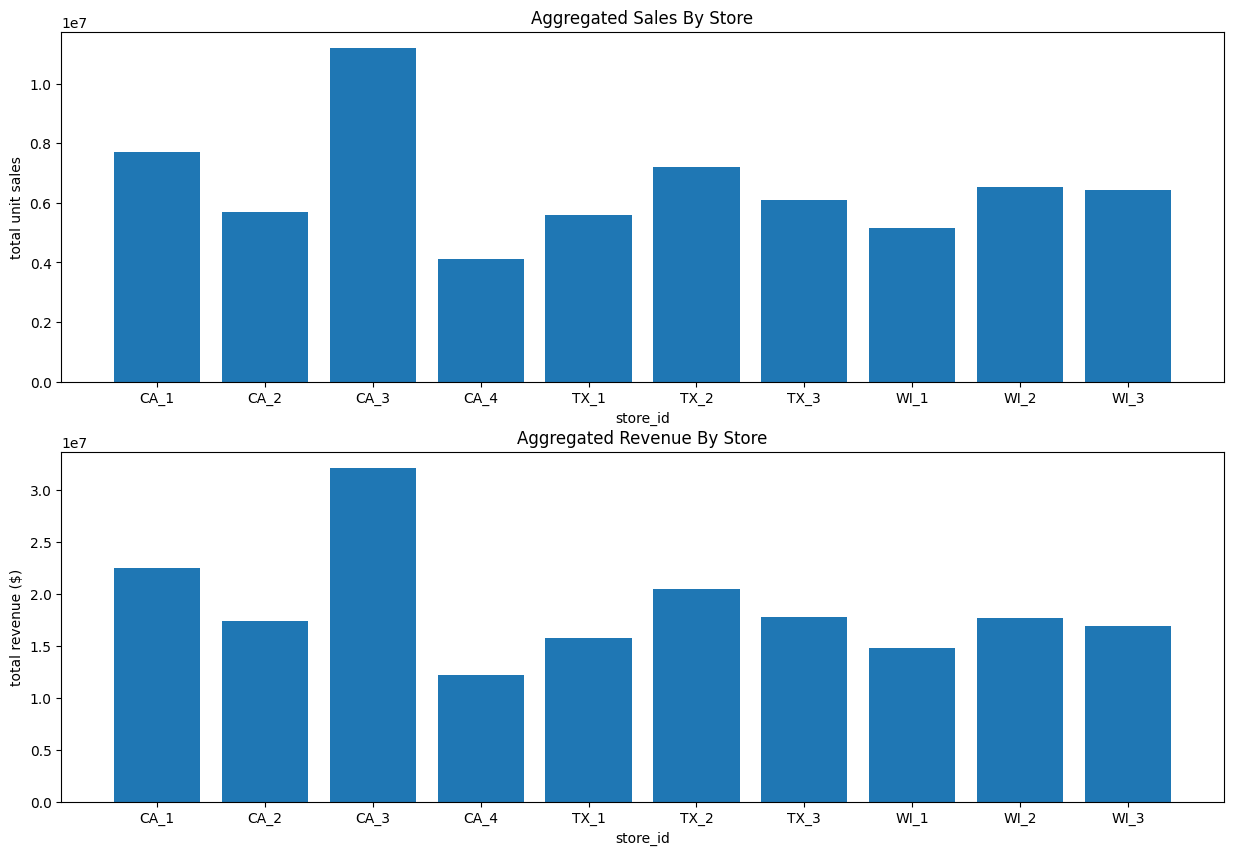

In [13]:
# grouped by store as well
sales_by_store_id = df.groupby(["store_id"]).agg({"sold": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

fig, axs = plt.subplots(2,1, figsize = (15,10))
ax = axs[0]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.sold)
ax.set_title("Aggregated Sales By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total unit sales")

df_c = df.copy()
df_c["sell_price"] = df_c["sell_price"].fillna(0)
df_c["revenue"] = df_c["sold"] * df_c["sell_price"]
sales_by_store_id = df_c.groupby(["store_id"]).agg({"revenue": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

ax = axs[1]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.revenue)
ax.set_title("Aggregated Revenue By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total revenue ($)")
plt.show()

In [58]:
df["price_quantile"] = pd.qcut(df["sell_price"], 20, labels=[f'q_{round(i,2)}' for i in np.arange(0.05,1.05, 0.05)], )
df.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release,price_quantile
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,0,0.459961,11101,q_0.05
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,0,1.559570,11101,q_0.15
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,0,3.169922,11101,q_0.5
11,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,0,5.980469,11101,q_0.8
14,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4,2011-01-29,11101,...,NaN,NaN,NaN,NaN,0,0,0,0.700195,11101,q_0.05


### Sales Correlated to Sell Price

In [ ]:
sales_by_price_quantile = df.groupby(['price_quantile', 'd'])['sold'].sum().reset_index(drop=False)#.sort_values("price_quantile", ascending=True)
sales_by_price_quantile = sales_by_price_quantile.groupby(['price_quantile'])['sold'].mean().reset_index(drop=False)

fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.bar(sales_by_price_quantile.price_quantile, sales_by_price_quantile.sold)
ax.set_title("Aggregated Sales By Price Quantile")
ax.set_xlabel("price_quantile")
ax.set_ylabel("total unit sales")
plt.show()

### Autocorrelation Plots 

NameError: name 'res' is not defined

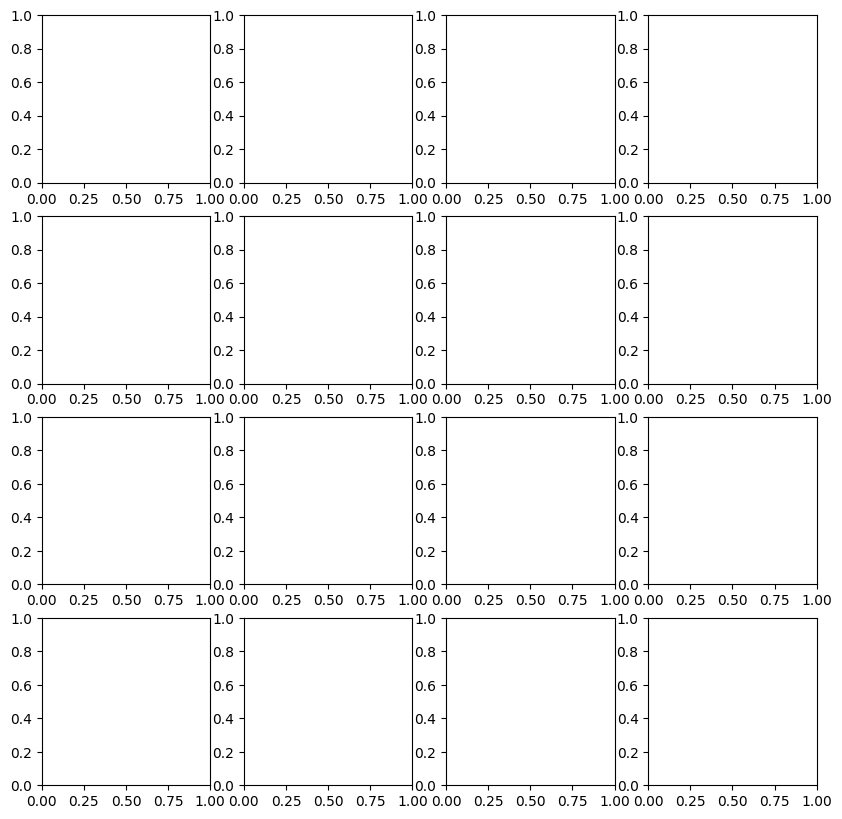

In [92]:
n = 4
m = 4
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    plot_pacf(df[df["id"] == res.index[k]]["sold"].dropna(), ax = ax)
plt.show()

n = 4
m = 4
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    ax.hist(df[df["id"] == res.index[k]]["sold"].dropna(), bins = 50)
axs[0,1].set_title("histogram of sales")
plt.show()

n = 50
sns.heatmap(pd.DataFrame(dict(zip(
    res.index[:n], 
    [
        df[df["id"] == id]["sold"].dropna().values 
        for id in res.index[:n]
    ]
))).corr())
plt.show()

n = 50
sns.heatmap(pd.DataFrame(dict(zip(
    res.index[-n:], 
    [
        df[df["id"] == id]["sold"].dropna().values 
        for id in res.index[-n:]
    ]
))).corr())
plt.show()

fig, axs = plt.subplots(1,1, figsize = (10,5))
for id in res.index[-10:]:
    axs.plot(df[df["id"] == id]["date"], df[df["id"] == id]["sold"])
plt.show()

In [81]:
z = "FOODS_3_090_CA_1_validation"
x = df[df["id"] == z]["date"].iloc[500:1000]
y = df[df["id"] == z]["sold"].iloc[:100000]

for alpha in np.arange(0.01, 0.9, 0.05):
    y_pred = y.ewm(alpha = alpha, adjust=False).mean().shift(1)
    # plt.scatter(x, y, s=.5)
    # plt.plot(x, y_pred, "r")
    # plt.show()
    # plt.plot(x, y - y_pred)
    # plt.show()  
    print(alpha, np.std(y - y_pred))

0.01 53.396145724755655
0.060000000000000005 44.2853790315104
0.11 42.0383255882799
0.16000000000000003 41.1065019182285
0.21000000000000002 40.663148170418744
0.26 40.44887649140651
0.31000000000000005 40.356980459896256
0.36000000000000004 40.33435489831812
0.41000000000000003 40.35209672232752
0.46 40.394670137770916
0.51 40.454875108946716
0.56 40.53099329012531
0.6100000000000001 40.624917524151336
0.66 40.740821248424
0.7100000000000001 40.884193070259705
0.76 41.06116335926443
0.81 41.2780832249734
0.8600000000000001 41.54132240659683


###

<Axes: >

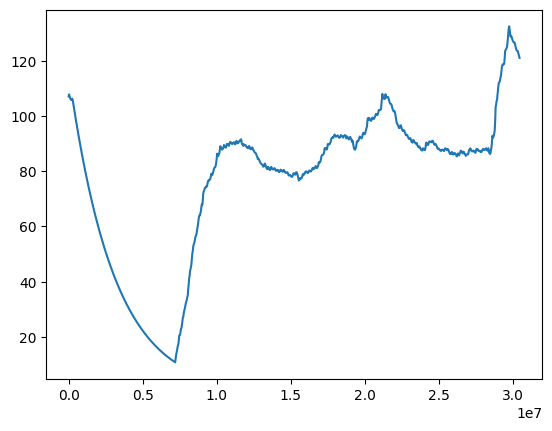

In [55]:
y.ewm(alpha=.01, adjust=False).mean().plot()